In [19]:
import time
from math import sqrt
import matplotlib.pyplot as plt
import random
import env_sim
import env6
from liquid_net import LiquidNet
import os
import numpy as np
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pytorch_lightning as pl


from ncps.wirings import AutoNCP 
from ncps.torch import LTC
import seaborn as sns


In [20]:
import torch
from liquid_net import LiquidNet

# Create an LiquidNet with a specified number of units
num_units = 64
model = LiquidNet(num_units)

# Generate random input data with batch size 4 and input size 32
batch_size = 1
input_size = 32
inputs = torch.randn(batch_size, input_size)

# Initialize the cell state (hidden state)
initial_state = torch.zeros(batch_size, num_units)

# Forward pass through the LiquidNet
outputs, final_state = model(inputs, initial_state)

# Print the shape of outputs and final_state
print("Outputs shape:", outputs.shape)
print("Final state shape:", final_state.shape)
print(inputs)

Outputs shape: torch.Size([1, 64])
Final state shape: torch.Size([1, 64])
tensor([[ 0.2690, -2.1190,  0.2961,  0.0733, -0.6879, -0.1062,  0.3987,  0.7193,
          0.7982, -0.1229,  0.9714,  1.2196,  0.6751,  0.4122, -2.1010, -0.8965,
          0.9171, -0.6082,  3.1607,  0.6261, -0.2529, -0.5722, -0.3302,  2.0056,
         -1.6654, -1.5131,  0.0933, -0.9930, -0.1523, -0.9254,  1.5026,  0.1976]])


In [21]:
class ExperienceDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        return tuple(map(lambda t: t[ind], self.data))

def create_shuffled_dataloader(data, batch_size, shuffle = True):
    ds = ExperienceDataset(data)
    return DataLoader(ds, batch_size = batch_size, shuffle = True)

In [22]:
# class PolicyNetwork(torch.nn.Module):
#     def __init__(self,state_dims, n_actions):
#         super(PolicyNetwork, self).__init__()
#         self.liquid_net = LiquidNet(64)
#         self.fc1 = torch.nn.Linear(64, 32)
#         self.fc2 = torch.nn.Linear(32, n_actions)
#         torch.nn.init.kaiming_uniform_(self.fc1.weight)
#         torch.nn.init.kaiming_uniform_(self.fc2.weight)

#         self.hidden_state = None

#     def forward(self, x):
#         # Initialize the hidden state if it is the first pass
#         if self.hidden_state is None:
#             self.hidden_state = torch.zeros(x.size(0), self.liquid_net.state_size).to(
#                 x.device
#             )
#         # Forward pass through the liquidnet
#         liquid_out, self.hidden_state = self.liquid_net(x, self.hidden_state)
#         actor_out = torch.tanh(self.fc1(liquid_out))
#         actor_out = self.fc2(actor_out)
#         policy = torch.nn.functional.softmax(actor_out, dim=-1) 

#         return policy
    

# class ValueNetwork(torch.nn.Module):
#     def __init__(self,state_dims):
#         super(ValueNetwork, self).__init__()
#         self.liquid_net = LiquidNet(64)
#         self.fc1 = torch.nn.Linear(64, 32)
#         self.fc2 = torch.nn.Linear(32, 1)
#         torch.nn.init.kaiming_uniform_(self.fc1.weight)
#         torch.nn.init.kaiming_uniform_(self.fc2.weight)

#         self.hidden_state = None

#     def forward(self, x):
#         # Initialize the hidden state if it is the first pass
#         if self.hidden_state is None:
#             self.hidden_state = torch.zeros(x.size(0), self.liquid_net.state_size).to(
#                 x.device
#             )
#         # Forward pass through the liquidnet
#         liquid_out, self.hidden_state = self.liquid_net(x, self.hidden_state)
#         critic_out = torch.tanh(self.fc1(liquid_out))
#         value = self.fc2(critic_out)
#         return value

class PolicyNetwork(torch.nn.Module):
    def __init__(self,state_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.wiring = AutoNCP(16,n_actions)

        self.fc1 = torch.nn.Linear(state_dims, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.ltc = LTC(32, self.wiring)

        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)

        self.hidden_state = None

    def forward(self, x):
        # Initialize the hidden state if it is the first pass
        if self.hidden_state is None:
            if x.size(0) > 1:
                self.hidden_state  = torch.zeros(x.size(0),16).to(x.device)
            else:
                self.hidden_state  = torch.zeros(16).to(x.device)

        # print(f"Hx: {self.hidden_state}")  # Debugging
        # print(f"Input: {x.shape}")  # Debugging
        x = torch.tanh(self.fc1(x))
        # print(f"After fc1: {x.shape}")  # Debugging
        x = torch.tanh(self.fc2(x))
        # print(f"After fc2: {x.shape}")  # Debugging
        x, self.hidden_state = self.ltc(x, self.hidden_state)
        # print(f"After LTC: x={x.shape}, hx={self.hidden_state.shape}")  # Debugging
        policy = torch.nn.functional.softmax(x, dim=-1)
        # print(f"Policy: {policy.shape}")  # Debugging
    

        return policy#, self.hidden_state 
    

class ValueNetwork(torch.nn.Module):
    def __init__(self,state_dims):
        super(ValueNetwork, self).__init__()
        self.wiring = AutoNCP(16,1)

        self.fc1 = torch.nn.Linear(state_dims, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.ltc = LTC(32, self.wiring)

        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)

        self.hidden_state = None

    def forward(self, x):
        # Initialize the hidden state if it is the first pass
        if self.hidden_state is None:
            if x.size(0) > 1:
                self.hidden_state  = torch.zeros(x.size(0),16).to(x.device)
            else:
                self.hidden_state  = torch.zeros(16).to(x.device)

        # print(f"Hx: {self.hidden_state}")  # Debugging
        # print(f"Input: {x.shape}")  # Debugging
        x = torch.tanh(self.fc1(x))
        # print(f"After fc1: {x.shape}")  # Debugging
        x = torch.tanh(self.fc2(x))
        # print(f"After fc2: {x.shape}")  # Debugging
        value, self.hidden_state = self.ltc(x, self.hidden_state)
        # print(f"After LTC: x={x.shape}, hx={self.hidden_state.shape}")  # Debugging

        return value#, self.hidden_state 

def np_to_tensor(x):
    return torch.tensor(x).to(torch.float32)

    
policy_model = PolicyNetwork(state_dims=6, n_actions = 6)
value_model = ValueNetwork(state_dims=6)

In [23]:

# LightningModule for training a RNNSequence module
class SequenceLearnerPolicy(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        states, actions, action_log, advantages, values = batch

        new_action_probs = self.model.forward(states).squeeze()
        dist = torch.distributions.Categorical(new_action_probs)

        new_action_logs = dist.log_prob(actions)
        entropy = dist.entropy()

        # compute PPO-Clip
        ratios = torch.exp(new_action_logs - action_log)
        surr1 = ratios * advantages
        surr2 = ratios.clamp(1 - 0.2, 1 + 0.2) * advantages
        policy_loss = -torch.mean(torch.min(surr1, surr2) - 0.01 * entropy)

        self.model.hidden_state = self.model.hidden_state.detach()
        
        return {"loss": policy_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

class SequenceLearnerValue(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        states, actions, action_log, advantages, values = batch

        new_values = self.value_net(states).squeeze()
        value_clipped = values + (new_values - values).clamp(-0.4, 0.4)
        value_loss_1 = (value_clipped.flatten() - advantages) ** 2
        value_loss_2 = (values.flatten() - advantages) ** 2
        value_loss = torch.mean(torch.max(value_loss_1, value_loss_2))
        self.model.hidden_state = self.model.hidden_state.detach()

        return {"loss": value_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

PolicyNetwork(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (ltc): LTC(
    (rnn_cell): LTCCell(
      (make_positive_fn): Softplus(beta=1.0, threshold=20.0)
      (_clip): ReLU()
    )
  )
) ValueNetwork(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (ltc): LTC(
    (rnn_cell): LTCCell(
      (make_positive_fn): Softplus(beta=1.0, threshold=20.0)
      (_clip): ReLU()
    )
  )
)


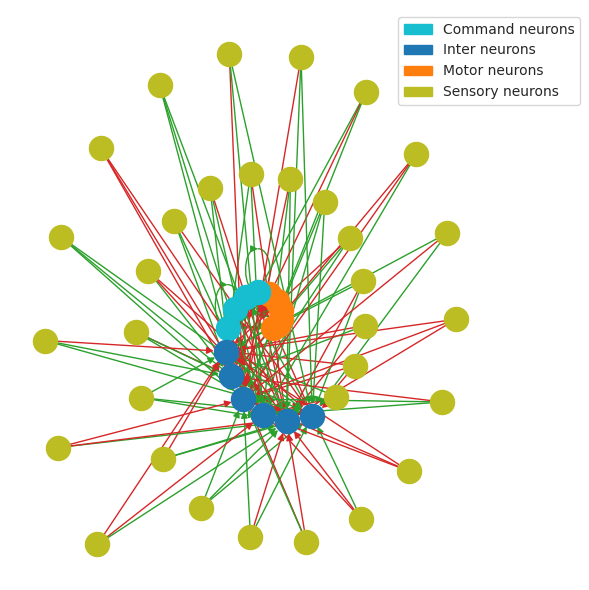

In [24]:
print(policy_model,value_model)
# summary(policy_model, input_size=(1, 6))
# summary(value_model, input_size=(1, 6))

sns.set_style("white")
plt.figure(figsize=(6, 6))
legend_handles = policy_model.wiring.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [25]:
class PPO:
    def __init__(self, state_dim=6, action_dim=6, policy_lr=0.0005, value_lr=0.001, 
                 gamma=0.99, lam=0.95, beta_s=0.01,epsilon_clip=0.2, value_clip=0.4, 
                 epochs=5,batch_size=50,save_path='Models',env=None):
        
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.value_net = ValueNetwork(state_dim).to(device)
        # self.policy_net.apply(weights_init)
        # self.value_net.apply(weights_init)

        # self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        # self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=value_lr)

        self.gamma = gamma
        self.lamda = lam
        self.epsilon_clip = epsilon_clip
        self.value_clip = value_clip
        self.beta_s = beta_s
        self.epochs = epochs
        self.action_dim = action_dim
        self.batch_size = batch_size

        self.env = env
        self.env.run()

        self.save_path = save_path
        self.env_name = "auto-docking-iss"

        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
        self.path = str(self.env_name)+'_PPO_'
        self.model_name = os.path.join(self.save_path, self.path)

        self.trajectory = {'states':[],'actions':[], 'rewards':[], 'action_logs':[],
                           'values':[],'done':[]}
        
        self.scores, self.episodes, self.average = [],[],[]
        self.value_loss_mean, self.policy_loss_mean = [], []

    def save(self,episode,score):
        torch.save({
            'actor': self.policy_net.state_dict(),
            'critic': self.value_net.state_dict()
        }, f'./'+ self.model_name + '_' + str(episode) + '_' + str(round(score,4)) + '.pt')

    def load(self,name):
        print(f'./{name}')
        try:
            data = torch.load(f'./{name}')
            self.policy_net.load_state_dict(data['actor'])
            self.value_net.load_state_dict(data['critic'])
        except Exception as e:
            print(e)

    # Función para visualizar la evolución del entrenamiento
    def plot_model(self, score, episode,num_episodes):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-10:]) / len(self.scores[-10:]))
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(1,figsize=(18, 9))
            plt.plot(self.episodes, self.scores, 'b')
            plt.plot(self.episodes, self.average, 'r')
            plt.ylabel('Score', fontsize=18)
            plt.xlabel('Steps', fontsize=18)
            try:
                plt.savefig(self.model_name+"scores.png")
            except OSError:
                pass

        return self.average[-1]
    
    def plot_loss(self,episode,num_episodes):        
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(2,figsize=(18, 9))
            plt.plot(self.episodes, self.policy_loss_mean, 'b')
            plt.plot(self.episodes, self.value_loss_mean, 'r')
            plt.ylabel('Loss', fontsize=18)
            plt.xlabel('Steps', fontsize=18)
            try:
                plt.savefig(self.model_name+"loss.png")
            except OSError:
                pass
    

    #Almacenamiento de todas las variables que definen una transición para PPO
    def collect_trayectory(self,state,action,action_logs,reward,done,value):
        self.trajectory['states'].append(state)
        self.trajectory['actions'].append(action)
        self.trajectory['rewards'].append(reward)
        self.trajectory['values'].append(value)
        self.trajectory['action_logs'].append(action_logs)
        self.trajectory['done'].append(done)
    
    def clear_trayectory(self):
        for key in self.trajectory.keys():
            self.trajectory[key].clear()
    
    def generalized_advantage_estimation(self,next_state):
        advantages = np.zeros_like(self.trajectory['rewards'])
        last_gae_lambda = 0
        self.trajectory['values'].append(self.value_net(next_state.unsqueeze(0)).squeeze().detach())

        for t in reversed(range(len(self.trajectory['rewards']))):
            delta = self.trajectory['rewards'][t]+ self.gamma * self.trajectory['values'][t + 1].item() - self.trajectory['values'][t].item()
            advantages[t] = last_gae_lambda = delta + self.gamma * self.lamda * last_gae_lambda
        
        return np_to_tensor(advantages)


    def learn_from_episode_trajectory(self,next_state):
        self.policy_net.train()
        self.value_net.train()

        states = deepcopy(self.trajectory['states'])
        actions = deepcopy(self.trajectory['actions'])
        # rewards = deepcopy(self.trajectory['rewards'])
        values = deepcopy(self.trajectory['values'])
        action_logs = deepcopy(self.trajectory['action_logs'])
        # done = deepcopy(self.trajectory['done'])

        advantages = self.generalized_advantage_estimation(next_state).to(device)

        # prepare dataloader for policy phase training
        dl = create_shuffled_dataloader([states, actions, action_logs, advantages, values], self.batch_size,False)

        policy_loss_array = []
        value_loss_array = []

        learn_policy = SequenceLearnerPolicy(self.policy_net, lr=0.0005)
        learn_values = SequenceLearnerPolicy(self.value_net, lr=0.001)

        trainer = pl.Trainer(
            max_epochs=4,
            gradient_clip_val=1,  # Clip gradient to stabilize training
        )

        trainer.fit(learn_policy, dl)
        trainer.fit(learn_values, dl)


        # for i in range(self.epochs):
        #     # self.policy_net.hidden_state = None
        #     # self.value_net.hidden_state = None

        #     for states, actions, action_log, advantages, values in dl:
        #         #Update policy_net
        #         new_action_probs = self.policy_net(states).squeeze()
        #         dist = torch.distributions.Categorical(new_action_probs)

        #         new_action_logs = dist.log_prob(actions)
        #         entropy = dist.entropy()

        #         # compute PPO-Clip
        #         ratios = torch.exp(new_action_logs - action_log)
        #         surr1 = ratios * advantages
        #         surr2 = ratios.clamp(1 - self.epsilon_clip, 1 + self.epsilon_clip) * advantages
        #         policy_loss = -torch.mean(torch.min(surr1, surr2) - self.beta_s * entropy)
        #         policy_loss_array.append(policy_loss.detach().numpy())

        #         self.policy_optimizer.zero_grad() # Clean gradients
        #         policy_loss.mean().backward() # Compute gradients
        #         self.policy_optimizer.step() #Update weights

        #         #Update value_net
        #         new_values = self.value_net(states).squeeze()
        #         value_clipped = values + (new_values - values).clamp(-self.value_clip, self.value_clip)
        #         value_loss_1 = (value_clipped.flatten() - advantages) ** 2
        #         value_loss_2 = (values.flatten() - advantages) ** 2
        #         value_loss = torch.mean(torch.max(value_loss_1, value_loss_2))
        #         value_loss_array.append(value_loss.detach().numpy())

        #         self.value_optimizer.zero_grad() # Clean gradients
        #         value_loss.backward() # Compute gradients 
        #         self.value_optimizer.step() #Update weights

        #         self.policy_net.hidden_state = self.policy_net.hidden_state.detach()
        #         self.value_net.hidden_state = self.value_net.hidden_state.detach()
            
        # self.value_loss_mean.append(sum(value_loss_array)/self.epochs)
        # self.policy_loss_mean.append(sum(policy_loss_array)/self.epochs)

        # print(f"\n Mean Policy loss: {self.value_loss_mean[-1]:.4f}. Mean Value loss: {self.policy_loss_mean[-1]:.4f}")
        
        self.policy_net.eval()
        self.value_net.eval()


    # Función para resetear el entorno tras acabar trayectoria
    def reset(self):
        state = self.env.reset()
        return np_to_tensor(self.process_state(state))
    
     # Función para interacción agente-entorno
    def step(self, action):
        next_state, reward, done = self.env.step(action)
        next_state = self.process_state(next_state)
        return np_to_tensor(next_state), reward, done

    def process_state(self,state):
        state_processed = np.array(state)
        state_processed[0] = state_processed[0] / 30 # Position array
        state_processed[1] = state_processed[1] / 3 # Position array
        state_processed[2] = state_processed[2] / 3 # Position array
        return state_processed
    
    def train(self,num_episodes=200,max_steps=200,dt=0.01):
        average = 0
        self.policy_net.eval()
        self.value_net.eval()

        max_score_average = -5000

        for episode in range(1,num_episodes+1):
            self.clear_trayectory()

            state = self.reset()
            score = 0

            SAVING = ""
            self.policy_net.hidden_state = None
            self.value_net.hidden_state = None

            for step in range(1,max_steps+1):
                action_probs = self.policy_net(state.unsqueeze(0)).squeeze().detach()
                dist = torch.distributions.Categorical(action_probs)
                action = dist.sample()
                action_log = dist.log_prob(action)
                # print(action,action_probs,action_log)

                value = self.value_net(state.unsqueeze(0)).squeeze().detach()
                
                next_state,reward,done = self.step(action.item())    
                self.collect_trayectory(state,action,action_log,reward,done,value)

                state = next_state

                score += reward

                # print(state)
                # print(f'\rSteps: {step}/{max_steps}. Action: {action}. Reward/Value: {round(reward,2)}/{round(value.item(),4)}. Done: {done}', end='', flush=True)

                if done:
                    break
                
                # time.sleep(dt)

            self.learn_from_episode_trajectory(next_state)
            self.clear_trayectory()

            average = self.plot_model(score, episode,num_episodes)
            # self.plot_loss(episode,num_episodes)
            
            if episode > 40 and average >= max_score_average:
                max_score_average = average
                self.save(episode,average)
                SAVING = "SAVING"
            # elif episode % 10 == 0:
            #     self.save(episode,average)
            #     SAVING = "SAVING"
            else:
                SAVING = ""
            
            print(f"\rEpisode: {episode}/{num_episodes}, score/average: {score:.4f}/{average:.4f} {SAVING}", end='', flush=True)


        # close environemnt when finish training
        self.save(episode,average)

    def test(self,max_steps,dt=0.01):
        self.policy_net.eval()
        self.value_net.eval()

        self.clear_trayectory()
        state = self.reset()
        score = 0

        self.policy_net.hidden_state = None
        self.value_net.hidden_state = None

        for step in range(1,max_steps+1):
            action_probabilities = self.policy_net(state.unsqueeze(0))
            action = torch.argmax(action_probabilities, dim=-1).item()#np.argmax(self.policy_net(state).squeeze().detach().numpy())
            value = self.value_net(state.unsqueeze(0)).squeeze().detach()
            
            next_state,reward,done = self.step(action)    

            state = next_state

            score += reward

            print(f'\rSteps: {step}/{max_steps}. Action: {action}. Score/Value: {round(score,2)}/{round(value.item(),4)}. Done: {done}', end='', flush=True)

            if self.env.done or step > max_steps:
                break
                
            time.sleep(dt)
        
        print(f'\nNext state: {state}')


In [26]:
dt = 0.5
env = env_sim.Env(dt=dt)
agent = PPO(save_path='Models12-2',env=env,batch_size=500)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer

Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=12]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_12/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 1/400, score/average: -1166.0530/-1166.0530 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=13]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=13]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_13/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 2/400, score/average: -740.1962/-953.1246 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, v_num=14]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s, v_num=14]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_14/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 3/400, score/average: -411.9484/-772.7325 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, v_num=15]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, v_num=15]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_15/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 4/400, score/average: -358.2997/-669.1243 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, v_num=16]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_16/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 5/400, score/average: -498.0798/-634.9154 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=17]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_17/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 6/400, score/average: -636.5186/-635.1826 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s, v_num=18]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, v_num=18]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_18/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 7/400, score/average: -451.7072/-608.9718 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, v_num=19]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, v_num=19]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_19/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 8/400, score/average: -692.3677/-619.3963 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s, v_num=20]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s, v_num=20]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_20/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 9/400, score/average: -511.0620/-607.3592 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=21]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=21]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_21/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 10/400, score/average: -542.2169/-600.8449 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, v_num=22]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s, v_num=22]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_22/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 11/400, score/average: -489.9349/-533.2331 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, v_num=23]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, v_num=23]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_23/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 12/400, score/average: -420.9725/-501.3108 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=24]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=24]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_24/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 13/400, score/average: -606.1901/-520.7349 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=25]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s, v_num=25]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_25/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 14/400, score/average: -746.4005/-559.5450 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s, v_num=26]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, v_num=26]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_26/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 15/400, score/average: -444.2140/-554.1584 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=27]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, v_num=27]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_27/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 16/400, score/average: -630.9574/-553.6023 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=28]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=28]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_28/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 17/400, score/average: -537.8376/-562.2154 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s, v_num=29]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, v_num=29]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_29/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 18/400, score/average: -413.3369/-534.3123 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, v_num=30]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, v_num=30]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_30/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 19/400, score/average: -407.7187/-523.9779 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=31]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=31]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_31/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 20/400, score/average: -635.3915/-533.2954 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s, v_num=32]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s, v_num=32]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_32/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 21/400, score/average: -609.3723/-545.2392 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, v_num=33]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, v_num=33]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_33/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 22/400, score/average: -360.0534/-539.1472 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=34]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=34]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_34/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 23/400, score/average: -227.2121/-501.2494 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s, v_num=35]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, v_num=35]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_35/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 24/400, score/average: -726.0143/-499.2108 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s, v_num=36]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s, v_num=36]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_36/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 25/400, score/average: -779.5195/-532.7414 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, v_num=37]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, v_num=37]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_37/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 26/400, score/average: -694.1749/-539.0631 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=38]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=38]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_38/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 27/400, score/average: -999.8413/-585.2635 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=39]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=39]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_39/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 28/400, score/average: -433.4546/-587.2753 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=40]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=40]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_40/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 29/400, score/average: -872.0800/-633.7114 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=41]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=41]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_41/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 30/400, score/average: -647.2197/-634.8942 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s, v_num=42]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, v_num=42]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_42/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 31/400, score/average: -447.9250/-618.7495 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s, v_num=43]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s, v_num=43]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_43/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 32/400, score/average: -365.8461/-619.3288 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=44]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=44]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_44/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 33/400, score/average: -829.0247/-679.5100 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s, v_num=45]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s, v_num=45]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_45/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 34/400, score/average: -519.3194/-658.8405 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, v_num=46]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, v_num=46]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_46/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 35/400, score/average: -424.8097/-623.3695 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, v_num=47]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, v_num=47]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_47/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 36/400, score/average: -547.6602/-608.7181 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, v_num=48]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=48]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_48/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 37/400, score/average: -769.7673/-585.7107 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, v_num=49]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, v_num=49]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_49/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 38/400, score/average: -719.7674/-614.3419 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, v_num=50]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, v_num=50]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_50/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 39/400, score/average: -749.1902/-602.0530 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, v_num=51]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, v_num=51]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_51/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 40/400, score/average: -629.7409/-600.3051 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s, v_num=52]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s, v_num=52]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_52/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 41/400, score/average: -559.4363/-611.4562 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, v_num=53]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s, v_num=53]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_53/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 42/400, score/average: -349.9023/-609.8618 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=54]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, v_num=54]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_54/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 43/400, score/average: -360.9694/-563.0563 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s, v_num=55]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=55]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_55/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 44/400, score/average: -811.6521/-592.2896 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, v_num=56]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, v_num=56]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_56/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 45/400, score/average: -706.2143/-620.4300 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, v_num=57]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, v_num=57]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_57/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 46/400, score/average: -260.8829/-591.7523 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=58]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=58]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_58/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 47/400, score/average: -456.6605/-560.4416 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, v_num=59]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, v_num=59]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_59/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 48/400, score/average: -561.0289/-544.5678 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s, v_num=60]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s, v_num=60]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_60/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 49/400, score/average: -690.4432/-538.6931 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, v_num=61]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=61]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_61/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 50/400, score/average: -528.5614/-528.5751 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, v_num=62]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, v_num=62]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_62/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 51/400, score/average: -668.8422/-539.5157 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=63]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s, v_num=63]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_63/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 52/400, score/average: -826.7527/-587.2008 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s, v_num=64]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s, v_num=64]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_64/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 53/400, score/average: -393.3389/-590.4377 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s, v_num=65]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s, v_num=65]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_65/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 54/400, score/average: -378.5576/-547.1283 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=66]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=66]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_66/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 55/400, score/average: -333.9613/-509.9030 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s, v_num=67]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s, v_num=67]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_67/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 56/400, score/average: -676.1120/-551.4259 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, v_num=68]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, v_num=68]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_68/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 57/400, score/average: -778.9035/-583.6502 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=69]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=69]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_69/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 58/400, score/average: -463.6318/-573.9105 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s, v_num=70]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, v_num=70]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_70/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 59/400, score/average: -486.6042/-553.5266 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s, v_num=71]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s, v_num=71]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_71/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 60/400, score/average: -610.1412/-561.6846 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, v_num=72]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, v_num=72]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_72/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 61/400, score/average: -648.4349/-559.6438 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, v_num=73]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s, v_num=73]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_73/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 62/400, score/average: -451.8853/-522.1571 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=74]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=74]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_74/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 63/400, score/average: -364.7006/-519.2933 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=75]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=75]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_75/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 64/400, score/average: -471.7354/-528.6110 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, v_num=76]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, v_num=76]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_76/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 65/400, score/average: -557.9346/-551.0084 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, v_num=77]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, v_num=77]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_77/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 66/400, score/average: -478.6526/-531.2624 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=78]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, v_num=78]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_78/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 67/400, score/average: -673.4108/-520.7131 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=79]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, v_num=79]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_79/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 68/400, score/average: -669.1747/-541.2674 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=80]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=80]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_80/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 69/400, score/average: -527.6934/-545.3764 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, v_num=81]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, v_num=81]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_81/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 70/400, score/average: -718.3802/-556.2002 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=82]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=82]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_82/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 71/400, score/average: -640.1325/-555.3700 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, v_num=83]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, v_num=83]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_83/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 72/400, score/average: -399.1120/-550.0927 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, v_num=84]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s, v_num=84]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_84/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 73/400, score/average: -578.2599/-571.4486 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, v_num=85]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, v_num=85]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_85/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 74/400, score/average: -766.8553/-600.9606 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=86]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=86]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_86/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 75/400, score/average: -784.7035/-623.6375 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=87]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, v_num=87]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_87/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 76/400, score/average: -556.4831/-631.4205 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=88]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=88]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_88/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 77/400, score/average: -629.3923/-627.0187 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, v_num=89]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, v_num=89]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_89/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 78/400, score/average: -774.7677/-637.5780 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=90]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, v_num=90]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_90/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 79/400, score/average: -377.6799/-622.5766 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=91]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=91]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_91/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 80/400, score/average: -862.4664/-636.9852 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, v_num=92]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, v_num=92]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_92/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 81/400, score/average: -444.7421/-617.4462 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=93]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=93]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_93/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 82/400, score/average: -585.4323/-636.0782 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=94]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=94]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_94/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 83/400, score/average: -553.0489/-633.5571 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s, v_num=95]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s, v_num=95]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_95/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 84/400, score/average: -341.9161/-591.0632 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, v_num=96]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=96]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_96/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 85/400, score/average: -440.8729/-556.6802 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, v_num=97]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=97]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_97/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 86/400, score/average: -941.0757/-595.1394 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s, v_num=98]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s, v_num=98]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_98/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 87/400, score/average: -513.4493/-583.5451 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=99]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, v_num=99]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_99/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 88/400, score/average: -660.0281/-572.0712 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s, v_num=100]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s, v_num=100]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_100/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 89/400, score/average: -278.8601/-562.1892 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, v_num=101]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, v_num=101]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_101/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 90/400, score/average: -768.9850/-552.8410 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=102]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=102]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_102/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 91/400, score/average: -545.5902/-562.9259 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=103]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=103]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_103/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 92/400, score/average: -799.6485/-584.3475 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s, v_num=104]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, v_num=104]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_104/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 93/400, score/average: -568.8312/-585.9257 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, v_num=105]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, v_num=105]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_105/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 94/400, score/average: -625.5407/-614.2882 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, v_num=106]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s, v_num=106]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_106/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 95/400, score/average: -616.1195/-631.8128 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=107]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=107]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_107/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 96/400, score/average: -628.7539/-600.5806 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, v_num=108]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, v_num=108]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_108/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 97/400, score/average: -819.1195/-631.1477 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=109]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=109]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_109/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 98/400, score/average: -514.7452/-616.6194 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s, v_num=110]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s, v_num=110]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_110/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 99/400, score/average: -493.4999/-638.0834 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=111]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=111]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_111/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 100/400, score/average: -595.5161/-620.7365 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=112]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=112]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_112/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 101/400, score/average: -566.9165/-622.8691 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s, v_num=113]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, v_num=113]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_113/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 102/400, score/average: -453.5962/-588.2639 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=114]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=114]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_114/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 103/400, score/average: -408.1552/-572.1963 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=115]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=115]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_115/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 104/400, score/average: -521.7391/-561.8161 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, v_num=116]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, v_num=116]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_116/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 105/400, score/average: -674.2123/-567.6254 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=117]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=117]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_117/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 106/400, score/average: -416.5734/-546.4074 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=118]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=118]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_118/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 107/400, score/average: -306.6441/-495.1598 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s, v_num=119]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, v_num=119]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_119/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 108/400, score/average: -433.1207/-486.9974 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=120]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=120]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_120/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 109/400, score/average: -417.1568/-479.3630 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=121]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=121]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_121/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 110/400, score/average: -554.3413/-475.2456 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=122]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=122]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_122/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 111/400, score/average: -405.7903/-459.1329 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=123]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=123]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_123/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 112/400, score/average: -482.3282/-462.0061 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=124]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=124]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_124/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 113/400, score/average: -633.5402/-484.5446 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=125]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=125]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_125/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 114/400, score/average: -697.3589/-502.1066 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=126]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=126]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_126/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 115/400, score/average: -764.2538/-511.1108 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=127]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=127]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_127/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 116/400, score/average: -522.9273/-521.7462 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=128]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=128]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_128/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 117/400, score/average: -403.5564/-531.4374 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, v_num=129]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, v_num=129]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_129/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 118/400, score/average: -588.1479/-546.9401 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, v_num=130]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=130]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_130/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 119/400, score/average: -434.2912/-548.6536 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, v_num=131]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, v_num=131]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_131/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 120/400, score/average: -489.2135/-542.1408 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=132]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=132]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_132/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 121/400, score/average: -525.4966/-554.1114 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=133]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=133]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_133/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 122/400, score/average: -644.4928/-570.3279 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=134]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=134]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_134/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 123/400, score/average: -646.3875/-571.6126 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, v_num=135]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s, v_num=135]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_135/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 124/400, score/average: -490.7808/-550.9548 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, v_num=136]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, v_num=136]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_136/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 125/400, score/average: -536.4418/-528.1736 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s, v_num=137]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.00it/s, v_num=137]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_137/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 126/400, score/average: -280.4503/-503.9259 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, v_num=138]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=138]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_138/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 127/400, score/average: -666.1185/-530.1821 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=139]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=139]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_139/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 128/400, score/average: -536.7258/-525.0399 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=140]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=140]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_140/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 129/400, score/average: -395.2247/-521.1332 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=141]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=141]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_141/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 130/400, score/average: -847.1482/-556.9267 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, v_num=142]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, v_num=142]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_142/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 131/400, score/average: -903.1411/-594.6912 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=143]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=143]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_143/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 132/400, score/average: -628.0452/-593.0464 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=144]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=144]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_144/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 133/400, score/average: -522.9307/-580.7007 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=145]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=145]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_145/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 134/400, score/average: -387.0212/-570.3248 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s, v_num=146]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, v_num=146]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_146/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 135/400, score/average: -615.4386/-578.2244 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=147]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=147]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_147/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 136/400, score/average: -637.1790/-613.8973 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, v_num=148]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, v_num=148]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_148/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 137/400, score/average: -493.7693/-596.6624 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, v_num=149]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, v_num=149]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_149/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 138/400, score/average: -949.2253/-637.9123 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s, v_num=150]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s, v_num=150]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_150/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 139/400, score/average: -437.0380/-642.0937 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s, v_num=151]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s, v_num=151]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_151/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 140/400, score/average: -504.2661/-607.8055 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, v_num=152]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, v_num=152]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_152/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 141/400, score/average: -476.3945/-565.1308 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=153]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=153]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_153/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 142/400, score/average: -196.2388/-521.9502 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=154]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=154]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_154/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 143/400, score/average: -712.2765/-540.8847 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, v_num=155]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, v_num=155]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_155/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 144/400, score/average: -868.6088/-589.0435 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=156]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=156]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_156/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 145/400, score/average: -564.0471/-583.9043 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, v_num=157]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, v_num=157]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_157/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 146/400, score/average: -581.4511/-578.3316 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=158]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=158]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_158/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 147/400, score/average: -568.5767/-585.8123 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, v_num=159]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s, v_num=159]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_159/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 148/400, score/average: -463.3038/-537.2201 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=160]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=160]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_160/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 149/400, score/average: -390.9527/-532.6116 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=161]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=161]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_161/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 150/400, score/average: -505.3409/-532.7191 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, v_num=162]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, v_num=162]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_162/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 151/400, score/average: -381.6645/-523.2461 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=163]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=163]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_163/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 152/400, score/average: -345.3148/-538.1537 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=164]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=164]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_164/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 153/400, score/average: -620.3574/-528.9618 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, v_num=165]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, v_num=165]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_165/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 154/400, score/average: -567.8602/-498.8869 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, v_num=166]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s, v_num=166]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_166/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 155/400, score/average: -509.4322/-493.4254 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s, v_num=167]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s, v_num=167]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_167/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 156/400, score/average: -425.6008/-477.8404 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, v_num=168]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, v_num=168]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_168/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 157/400, score/average: -502.7777/-471.2605 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s, v_num=169]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s, v_num=169]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_169/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 158/400, score/average: -522.6601/-477.1961 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=170]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, v_num=170]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_170/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 159/400, score/average: -547.2286/-492.8237 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=171]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, v_num=171]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_171/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 160/400, score/average: -332.0843/-475.4981 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, v_num=172]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, v_num=172]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_172/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 161/400, score/average: -538.7055/-491.2022 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s, v_num=173]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s, v_num=173]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_173/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 162/400, score/average: -574.8110/-514.1518 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=174]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s, v_num=174]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_174/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 163/400, score/average: -812.5736/-533.3734 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=175]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=175]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_175/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 164/400, score/average: -288.0889/-505.3963 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=176]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=176]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_176/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 165/400, score/average: -664.8597/-520.9390 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s, v_num=177]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s, v_num=177]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_177/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 166/400, score/average: -441.8203/-522.5610 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s, v_num=178]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s, v_num=178]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_178/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 167/400, score/average: -431.7020/-515.4534 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s, v_num=179]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s, v_num=179]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_179/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 168/400, score/average: -627.7495/-525.9623 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=180]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=180]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_180/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 169/400, score/average: -420.9543/-513.3349 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=181]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=181]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_181/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 170/400, score/average: -173.1561/-497.4421 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=182]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=182]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_182/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 171/400, score/average: -391.0870/-482.6802 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s, v_num=183]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s, v_num=183]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_183/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 172/400, score/average: -537.7168/-478.9708 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=184]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=184]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_184/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 173/400, score/average: -867.3648/-484.4499 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=185]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=185]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_185/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 174/400, score/average: -822.9330/-537.9344 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, v_num=186]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, v_num=186]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_186/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 175/400, score/average: -533.6228/-524.8107 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=187]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=187]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_187/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 176/400, score/average: -626.5689/-543.2855 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s, v_num=188]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s, v_num=188]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_188/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 177/400, score/average: -340.9119/-534.2065 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s, v_num=189]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, v_num=189]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_189/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 178/400, score/average: -420.9371/-513.5253 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s, v_num=190]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s, v_num=190]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_190/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 179/400, score/average: -352.4636/-506.6762 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=191]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=191]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_191/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 180/400, score/average: -732.5631/-562.6169 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, v_num=192]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, v_num=192]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_192/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 181/400, score/average: -824.3715/-605.9453 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, v_num=193]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, v_num=193]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_193/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 182/400, score/average: -390.9444/-591.2681 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=194]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=194]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_194/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 183/400, score/average: -788.4855/-583.3802 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, v_num=195]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, v_num=195]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_195/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 184/400, score/average: -860.2007/-587.1069 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=196]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=196]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_196/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 185/400, score/average: -467.6334/-580.5080 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=197]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=197]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_197/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 186/400, score/average: -459.7917/-563.8303 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=198]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=198]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_198/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 187/400, score/average: -522.4489/-581.9840 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=199]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=199]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_199/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 188/400, score/average: -618.7273/-601.7630 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=200]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=200]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_200/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 189/400, score/average: -405.4587/-607.0625 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=201]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=201]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_201/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 190/400, score/average: -249.0120/-558.7074 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=202]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=202]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_202/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 191/400, score/average: -398.3247/-516.1027 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=203]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=203]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_203/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 192/400, score/average: -253.6151/-502.3698 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=204]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=204]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_204/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 193/400, score/average: -448.5602/-468.3773 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, v_num=205]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, v_num=205]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_205/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 194/400, score/average: -368.7291/-419.2301 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=206]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=206]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_206/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 195/400, score/average: -606.1209/-433.0789 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=207]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=207]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_207/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 196/400, score/average: -592.2893/-446.3286 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=208]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=208]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_208/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 197/400, score/average: -514.0165/-445.4854 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=209]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=209]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_209/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 198/400, score/average: -403.8048/-423.9931 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, v_num=210]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, v_num=210]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_210/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 199/400, score/average: -415.4793/-424.9952 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=211]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=211]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_211/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 200/400, score/average: -331.9509/-433.2891 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s, v_num=212]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s, v_num=212]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_212/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 201/400, score/average: -371.8548/-430.6421 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, v_num=213]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=213]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_213/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 202/400, score/average: -537.7194/-459.0525 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=214]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=214]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_214/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 203/400, score/average: -532.1903/-467.4155 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, v_num=215]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=215]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_215/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 204/400, score/average: -575.3943/-488.0820 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s, v_num=216]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s, v_num=216]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_216/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 205/400, score/average: -635.7697/-491.0469 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=217]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=217]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_217/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 206/400, score/average: -176.0248/-449.4205 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=218]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=218]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_218/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 207/400, score/average: -509.2114/-448.9400 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s, v_num=219]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s, v_num=219]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_219/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 208/400, score/average: -544.5465/-463.0141 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=220]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=220]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_220/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 209/400, score/average: -504.6190/-471.9281 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=221]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=221]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_221/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 210/400, score/average: -810.1047/-519.7435 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, v_num=222]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, v_num=222]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_222/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 211/400, score/average: -799.8424/-562.5423 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=223]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=223]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_223/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 212/400, score/average: -540.7129/-562.8416 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s, v_num=224]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, v_num=224]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_224/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 213/400, score/average: -666.9980/-576.3224 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=225]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=225]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_225/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 214/400, score/average: -740.7672/-592.8597 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=226]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=226]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_226/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 215/400, score/average: -386.6329/-567.9460 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=227]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=227]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_227/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 216/400, score/average: -813.8141/-631.7249 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, v_num=228]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s, v_num=228]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_228/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 217/400, score/average: -382.4424/-619.0480 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, v_num=229]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s, v_num=229]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_229/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 218/400, score/average: -433.8041/-607.9738 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s, v_num=230]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s, v_num=230]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_230/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 219/400, score/average: -601.3395/-617.6458 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, v_num=231]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, v_num=231]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_231/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 220/400, score/average: -532.9328/-589.9286 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=232]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, v_num=232]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_232/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 221/400, score/average: -609.3202/-570.8764 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, v_num=233]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, v_num=233]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_233/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 222/400, score/average: -588.8203/-575.6872 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=234]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=234]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_234/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 223/400, score/average: -451.8382/-554.1712 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=235]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=235]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_235/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 224/400, score/average: -275.5725/-507.6517 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=236]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=236]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_236/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 225/400, score/average: -828.1731/-551.8057 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=237]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=237]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_237/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 226/400, score/average: -396.1128/-510.0356 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=238]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=238]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_238/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 227/400, score/average: -566.7437/-528.4657 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=239]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=239]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_239/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 228/400, score/average: -537.5881/-538.8441 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=240]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=240]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_240/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 229/400, score/average: -358.2787/-514.5380 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=241]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=241]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_241/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 230/400, score/average: -314.1854/-492.6633 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=242]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=242]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_242/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 231/400, score/average: -379.8945/-469.7207 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=243]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=243]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_243/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 232/400, score/average: -659.6855/-476.8073 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=244]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=244]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_244/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 233/400, score/average: -295.7114/-461.1946 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s, v_num=245]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s, v_num=245]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_245/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 234/400, score/average: -282.2985/-461.8672 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=246]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=246]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_246/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 235/400, score/average: -304.3011/-409.4800 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, v_num=247]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s, v_num=247]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_247/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 236/400, score/average: -321.3808/-402.0068 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s, v_num=248]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s, v_num=248]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_248/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 237/400, score/average: -601.8898/-405.5214 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, v_num=249]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, v_num=249]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_249/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 238/400, score/average: -500.7365/-401.8362 SAVING

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, v_num=250]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, v_num=250]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_250/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 239/400, score/average: -528.7473/-418.8831 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=251]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=251]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_251/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 240/400, score/average: -485.7270/-436.0372 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s, v_num=252]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s, v_num=252]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_252/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 241/400, score/average: -372.9369/-435.3415 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s, v_num=253]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s, v_num=253]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_253/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 242/400, score/average: -326.5231/-402.0252 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=254]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=254]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_254/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 243/400, score/average: -538.8834/-426.3424 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=255]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=255]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_255/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 244/400, score/average: -210.2634/-419.1389 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s, v_num=256]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s, v_num=256]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_256/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 245/400, score/average: -543.2758/-443.0364 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s, v_num=257]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s, v_num=257]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_257/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


`Trainer.fit` stopped: `max_epochs=4` reached.


Episode: 246/400, score/average: -400.2490/-450.9232 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=258]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=258]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_258/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 247/400, score/average: -308.4727/-421.5815 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, v_num=259]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, v_num=259]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_259/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 248/400, score/average: -581.9161/-429.6995 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=260]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=260]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_260/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 249/400, score/average: -532.8710/-430.1118 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=261]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=261]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_261/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 250/400, score/average: -675.3066/-449.0698 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PolicyNetwork | 6.5 K  | train
------------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=262]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, v_num=262]

/home/saul/miniconda3/envs/miar_tfm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /media/saul/Datos/Asignaturas/09MIAR  - TFM/auto-docking-iss/lightning_logs/version_262/checkpoints exists and is not empty.

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | ValueNetwork | 6.5 K  | train
-----------------------------------------------
5.7 K     Trainable params
768       Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=4` reached.



Episode: 251/400, score/average: -566.1475/-468.3908 

KeyboardInterrupt: 

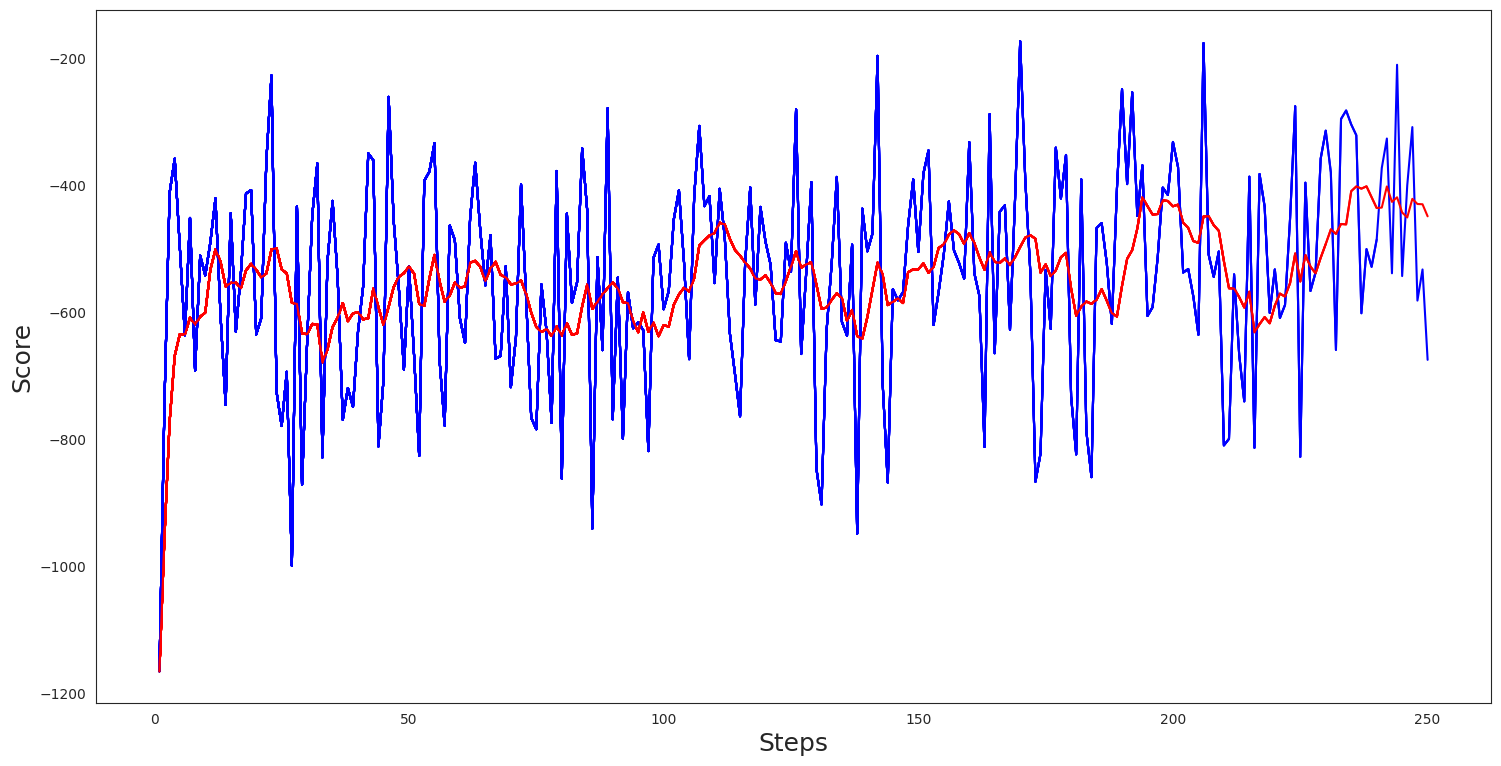

In [27]:
max_steps = 250
agent.train(num_episodes=400,max_steps=int(max_steps/dt))

In [7]:
agent.load("Models11/auto-docking-iss_PPO__363_277.3916.pt")

./Models11/auto-docking-iss_PPO__363_277.3916.pt


In [9]:
agent.test(500)

Steps: 158/500. Action: 4. Score/Value: 93.61/22.567. Done: 10
Next state: tensor([-0.0019,  0.0249, -0.0684, -0.1194,  0.0597, -0.0597])


In [6]:
env2 = env6.Env(port=5555)
agent2 = PPO(save_path='Models11',env=env2)

(13916) wsgi starting up on http://127.0.0.1:5555


(13916) accepted ('127.0.0.1', 48946)
(13916) accepted ('127.0.0.1', 48962)
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET / HTTP/1.1" 200 47837 0.002991
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET /css/normalize.css HTTP/1.1" 200 7079 0.001023
(13916) accepted ('127.0.0.1', 48972)
(13916) accepted ('127.0.0.1', 48976)
(13916) accepted ('127.0.0.1', 48986)
(13916) accepted ('127.0.0.1', 48992)
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET /css/layout.css HTTP/1.1" 200 42558 0.000698
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET /js/three/three.js HTTP/1.1" 200 945060 0.001449
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET /js/three/WebGL.js HTTP/1.1" 200 1810 0.000654
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET /js/three/GLTFLoader.js HTTP/1.1" 200 83956 0.000647
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET /js/three/CSS2DRenderer.js HTTP/1.1" 200 3743 0.000496
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET /js/gsap3/gsap.js HTTP/1.1" 200 114341 0.000575
127.0.0.1 - - [10/Aug/2024 16:03:09] "GET /js/gsap3/DrawSVGPl

In [7]:
agent2.load("Models11/auto-docking-iss_PPO__363_277.3916.pt")

./Models11/auto-docking-iss_PPO__363_277.3916.pt


In [ ]:
agent2.test(max_steps=500,dt=1.0)